# Demo - Probabilistic Fourier

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.AR
using LAR.DataAR

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file = "../data/obama.wav"   # specify sound location
fs_desired = 8000                 # specify desired sampling frequency

# input buffer parameters
step_size = 4                     # specify step size of buffer
buffer_size = 4                   # specify size of buffer

# probabilistic fourier parameters 
σ_observation = 0.00000001                # specify observation noise std
freq = collect(fs_desired/buffer_size:fs_desired/buffer_size:(fs_desired/2-fs_desired/buffer_size))

# ar modelling
AR_order = 10
iterations = 3
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[24*fs_time+1:27*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

## Visualize data

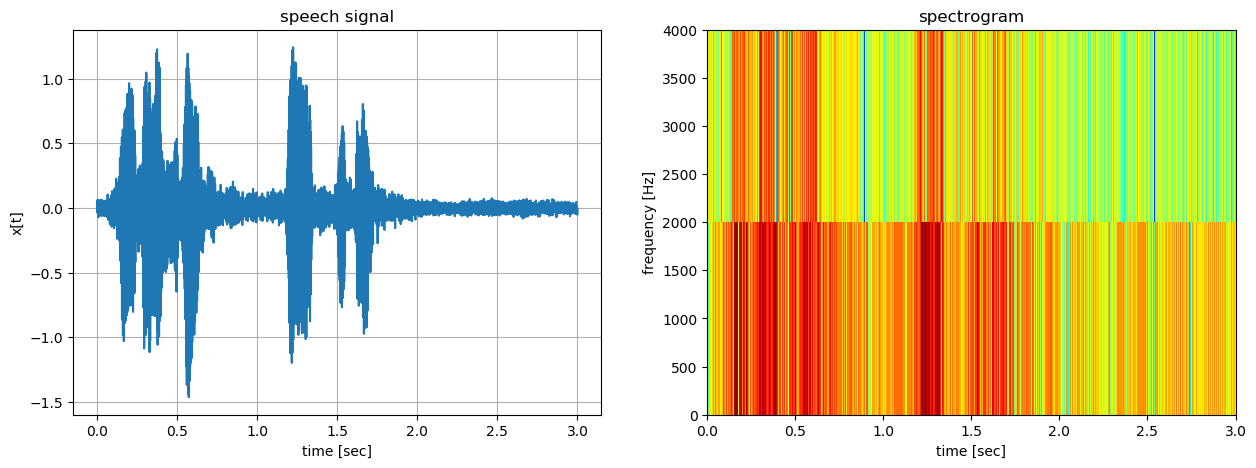

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq), buffer_size-step_size, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [5]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min = Array{Variable,1}(undef, 2*length(freq))
γ = Array{Variable,1}(undef, 2*length(freq))
θ = Array{Variable,1}(undef, 2*length(freq))
z = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), σ_observation^2*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min,k)] z_min[k] ~ GaussianMeanVariance(placeholder(pad(:μ_z_min, k), dims = (AR_order,)),
                                        placeholder(pad(:Σ_z_min, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:γ,k)] γ[k] ~ ForneyLab.Gamma(placeholder(pad(:a_γ,k)), placeholder(pad(:b_γ,k)))
    @RV [id=pad(:θ,k)] θ[k] ~ GaussianMeanVariance(placeholder(pad(:μ_θ,k), dims=(AR_order,)), placeholder(pad(:Σ_θ,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z,k)] z[k] ~ LAR.AR.Autoregressive(θ[k], z_min[k], γ[k])
end

# specify Fourier matrix
Ceme1 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme1[k] 
    placeholder(Ceme1[k], pad(:Ceme1,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x = sum(Ceme1.*z)
@RV y = x + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
# ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11172809049212637055 -->
 11172809049212637055 
 
 𝒩 
 gaussianmeanvariance_5 
 
<!-- 12048435738170991486 -->
 12048435738170991486 
 
 placeholder_μ_θ_02 
 
<!-- 11172809049212637055--12048435738170991486 -->
 11172809049212637055--12048435738170991486 
 
 μ_θ_02 
 1 out 
 2 m 
 
<!-- 2077803105156156453 -->
 2077803105156156453 
 
 placeholder_Σ_θ_02 
 
<!-- 11172809049212637055--2077803105156156453 -->
 11172809049212637055--2077803105156156453 
 
 Σ_θ_02 
 1 out 
 3 v 
 
<!-- 2278647900549564291 -->
 2278647900549564291 
 
 placeholder_y 
 
<!-- 14889223987246548220 -->
 14889223987246548220 
 
 + 
 addition_2 
 
<!-- 2278647900549564291--14889223987246548220 -->
 2278647900549564291--14889223987246548220 
 
 y 
 1 out 
 1 out 
 
<!-- 7795247382673379164 -->
 7795247382673379164 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 5394338575727174185 -->
 5394338575727174185 
 
 placeholder_μ_z_min_01 
 
<!-- 7795247382673379164--5394338575727174185 -->
 7795247382673379164--5394338575727174185 
 
 μ_z_min_01 
 1 out 
 2 m 
 
<!-- 14988148221076785862 -->
 14988148221076785862 
 
 placeholder_Σ_z_min_01 
 
<!-- 7795247382673379164--14988148221076785862 -->
 7795247382673379164--14988148221076785862 
 
 Σ_z_min_01 
 1 out 
 3 v 
 
<!-- 4368964094017450408 -->
 4368964094017450408 
 
 placeholder_μ_θ_01 
 
<!-- 17463620678545827261 -->
 17463620678545827261 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 9916132123752490102 -->
 9916132123752490102 
 
 clamp_1 
 
<!-- 17463620678545827261--9916132123752490102 -->
 17463620678545827261--9916132123752490102 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 6939404754679499780 -->
 6939404754679499780 
 
 clamp_2 
 
<!-- 17463620678545827261--6939404754679499780 -->
 17463620678545827261--6939404754679499780 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 12774601761371870067 -->
 12774601761371870067 
 
 placeholder_Σ_θ_01 
 
<!-- 11753049111897943311 -->
 11753049111897943311 
 
 + 
 addition_1 
 
<!-- 17460913321691880852 -->
 17460913321691880852 
 
 × 
 multiplication_2 
 
<!-- 11753049111897943311--17460913321691880852 -->
 11753049111897943311--17460913321691880852 
 
 variable_2 
 1 out 
 3 in2 
 
<!-- 1784086977377036283 -->
 1784086977377036283 
 
 × 
 multiplication_1 
 
<!-- 11753049111897943311--1784086977377036283 -->
 11753049111897943311--1784086977377036283 
 
 variable_1 
 1 out 
 2 in1 
 
<!-- 4010307825662772798 -->
 4010307825662772798 
 
 placeholder_a_γ_01 
 
<!-- 16953976933787023241 -->
 16953976933787023241 
 
 placeholder_b_γ_01 
 
<!-- 3045664274882178387 -->
 3045664274882178387 
 
 Gam 
 gamma_1 
 
<!-- 3045664274882178387--4010307825662772798 -->
 3045664274882178387--4010307825662772798 
 
 a_γ_01 
 1 out 
 2 a 
 
<!-- 3045664274882178387--16953976933787023241 -->
 3045664274882178387--16953976933787023241 
 
 b_γ_01 
 1 out 
 3 b 
 
<!-- 13735377918594648281 -->
 13735377918594648281 
 
 placeholder_Ceme1_1 
 
<!-- 7926731060997865529 -->
 7926731060997865529 
 
 𝒩 
 gaussianmeanvariance_3 
 
<!-- 7926731060997865529--4368964094017450408 -->
 7926731060997865529--4368964094017450408 
 
 μ_θ_01 
 1 out 
 2 m 
 
<!-- 7926731060997865529--12774601761371870067 -->
 7926731060997865529--12774601761371870067 
 
 Σ_θ_01 
 1 out 
 3 v 
 
<!-- 9014289546146499209 -->
 9014289546146499209 
 
 placeholder_μ_z_min_02 
 
<!-- 7550509599461006891 -->
 7550509599461006891 
 
 AR 
 autoregressive_2 
 
<!-- 7550509599461006891--11172809049212637055 -->
 7550509599461006891--11172809049212637055 
 
 θ_02 
 1 out 
 3 θ 
 
<!-- 1233

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, z, z_min, γ, ids=[:θ :z :z_min :γ])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorith 
eval(Meta.parse(algo))
;

In [7]:
println(algo)

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_02]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_02]))
messages[2] = ruleVariationalARIn3PPPN(marginals[:z_02], marginals[:z_min_02], marginals[:θ_02], nothing)
messages[3] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_01]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_01]))
messages[4] = ruleVariationalARIn3PPPN(marginals[:z_01], marginals[:z_min_01], marginals[:θ_01], nothing)

marginals[:γ_01] = messages[3].dist * messages[4].dist
marginals[:γ_02] = messages[1].dist * messages[2].dist

return marginals

end

function stepz_min!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBGaussianMeanVarianceOut(nothing, Pro

## Perform inference

In [8]:
messages=Array{Message}(undef, 12)
data = Dict()
marginals = Dict()

# create placeholders for priors
μ_z_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_z_min = Array{Array{Float64,2},1}(undef, 2*length(freq))
a_γ = Array{Float64,1}(undef, 2*length(freq))
b_γ = Array{Float64,1}(undef, 2*length(freq))
μ_θ = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_θ = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    μ_z_min[k] = zeros(AR_order)
    Σ_z_min[k] = 1e5*Ic(AR_order)
    a_γ[k] = 1
    b_γ[k] = 0.001
    μ_θ[k] = zeros(AR_order)
    Σ_θ[k] = 1e-10*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:γ, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=a_γ[k], b=b_γ[k])
    marginals[pad(:θ, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ[k], v=Σ_θ[k])
    marginals[pad(:z_min, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_z_min[k], v=Σ_z_min[k])
end

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x = Array{Float64,1}[]
Σ_x = Array{Float64,2}[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # fill data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        data[pad(:Ceme1,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
    end
    
    # infer parameters
    for it = 1:iterations
        
        # update data
        for f = 1:2*length(freq)
            data[pad(:a_γ, f)] = a_γ[f]
            data[pad(:b_γ, f)] = b_γ[f]
            data[pad(:μ_θ, f)] = μ_θ[f]
            data[pad(:Σ_θ, f)] = Σ_θ[f]
            data[pad(:μ_z_min, f)] = μ_z_min[f]
            data[pad(:Σ_z_min, f)] = Σ_z_min[f]
        end
        
        # perform steps (z last to get prediction of x)
        marginals = Base.invokelatest(stepz!, data, marginals, messages)  
            # update hidden states
    for f = 1:2*length(freq)
        μ_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
        Σ_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
        a_γ[f] = marginals[pad(:γ,f)].params[:a]
        b_γ[f] = marginals[pad(:γ,f)].params[:b]
        μ_θ[f] = ForneyLab.unsafeMean(marginals[pad(:θ,f)])
        Σ_θ[f] = ForneyLab.unsafeCov(marginals[pad(:θ,f)])
        data[pad(:a_γ, f)] = a_γ[f]
        data[pad(:b_γ, f)] = b_γ[f]
        data[pad(:μ_θ, f)] = μ_θ[f]
        data[pad(:Σ_θ, f)] = Σ_θ[f]
        data[pad(:μ_z_min, f)] = μ_z_min[f]
        data[pad(:Σ_z_min, f)] = Σ_z_min[f]
    end
        
        marginals = Base.invokelatest(stepz_min!, data, marginals, messages)
            # update hidden states
        for f = 1:2*length(freq)
            μ_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
            Σ_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
            a_γ[f] = marginals[pad(:γ,f)].params[:a]
            b_γ[f] = marginals[pad(:γ,f)].params[:b]
            μ_θ[f] = ForneyLab.unsafeMean(marginals[pad(:θ,f)])
            Σ_θ[f] = ForneyLab.unsafeCov(marginals[pad(:θ,f)])
            data[pad(:a_γ, f)] = a_γ[f]
            data[pad(:b_γ, f)] = b_γ[f]
            data[pad(:μ_θ, f)] = μ_θ[f]
            data[pad(:Σ_θ, f)] = Σ_θ[f]
            data[pad(:μ_z_min, f)] = μ_z_min[f]
            data[pad(:Σ_z_min, f)] = Σ_z_min[f]
        end
        
        marginals = Base.invokelatest(stepγ!, data, marginals, messages)
            # update hidden states
        for f = 1:2*length(freq)
            μ_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
            Σ_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
            a_γ[f] = marginals[pad(:γ,f)].params[:a]
            b_γ[f] = marginals[pad(:γ,f)].params[:b]
            μ_θ[f] = ForneyLab.unsafeMean(marginals[pad(:θ,f)])
            Σ_θ[f] = ForneyLab.unsafeCov(marginals[pad(:θ,f)])
            data[pad(:a_γ, f)] = a_γ[f]
            data[pad(:b_γ, f)] = b_γ[f]
            data[pad(:μ_θ, f)] = μ_θ[f]
            data[pad(:Σ_θ, f)] = Σ_θ[f]
            data[pad(:μ_z_min, f)] = μ_z_min[f]
            data[pad(:Σ_z_min, f)] = Σ_z_min[f]
        end
        
        marginals = Base.invokelatest(stepθ!, data, marginals, messages)
            # update hidden states
        for f = 1:2*length(freq)
            μ_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
            Σ_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
            a_γ[f] = marginals[pad(:γ,f)].params[:a]
            b_γ[f] = marginals[pad(:γ,f)].params[:b]
            μ_θ[f] = ForneyLab.unsafeMean(marginals[pad(:θ,f)])
            Σ_θ[f] = ForneyLab.unsafeCov(marginals[pad(:θ,f)])
            data[pad(:a_γ, f)] = a_γ[f]
            data[pad(:b_γ, f)] = b_γ[f]
            data[pad(:μ_θ, f)] = μ_θ[f]
            data[pad(:Σ_θ, f)] = Σ_θ[f]
            data[pad(:μ_z_min, f)] = μ_z_min[f]
            data[pad(:Σ_z_min, f)] = Σ_z_min[f]
        end

    end
    
    # run another time for prediction of x
    marginals = Base.invokelatest(stepz!, data, marginals, messages)  

    # estimate prediction of x
    push!(μ_x, ForneyLab.unsafeMean(messages[11].dist))
    push!(Σ_x, ForneyLab.unsafeCov(messages[11].dist))
    
    # update hidden states
    for f = 1:2*length(freq)
        μ_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
        Σ_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
        a_γ[f] = marginals[pad(:γ,f)].params[:a]
        b_γ[f] = marginals[pad(:γ,f)].params[:b]
        μ_θ[f] = ForneyLab.unsafeMean(marginals[pad(:θ,f)])
        Σ_θ[f] = ForneyLab.unsafeCov(marginals[pad(:θ,f)])
        data[pad(:a_γ, f)] = a_γ[f]
        data[pad(:b_γ, f)] = b_γ[f]
        data[pad(:μ_θ, f)] = μ_θ[f]
        data[pad(:Σ_θ, f)] = Σ_θ[f]
        data[pad(:μ_z_min, f)] = μ_z_min[f]
        data[pad(:Σ_z_min, f)] = Σ_z_min[f]
    end
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:27


In [9]:
a_γ, b_γ

([8999.5, 8999.5], [78.46328130214344, 79.5849375830708])

In [10]:
# convert μ_x to a 1d array
μ_x_pred = expand(reverse(hcat(μ_x...),dims=1))

# convert s_x to a 2d array
if length(size(μ_s)) != 2
    μ_s = hcat(μ_s...)
end

# calculate magnitude spectrum
mag_μ_s = log10.(sqrt.(μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), minimum(freq), maximum(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, buffer_size, buffer_size-step_size, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[1].set_ylim(minimum(freq), maximum(freq)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
;

UndefVarError: UndefVarError: μ_s not defined

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

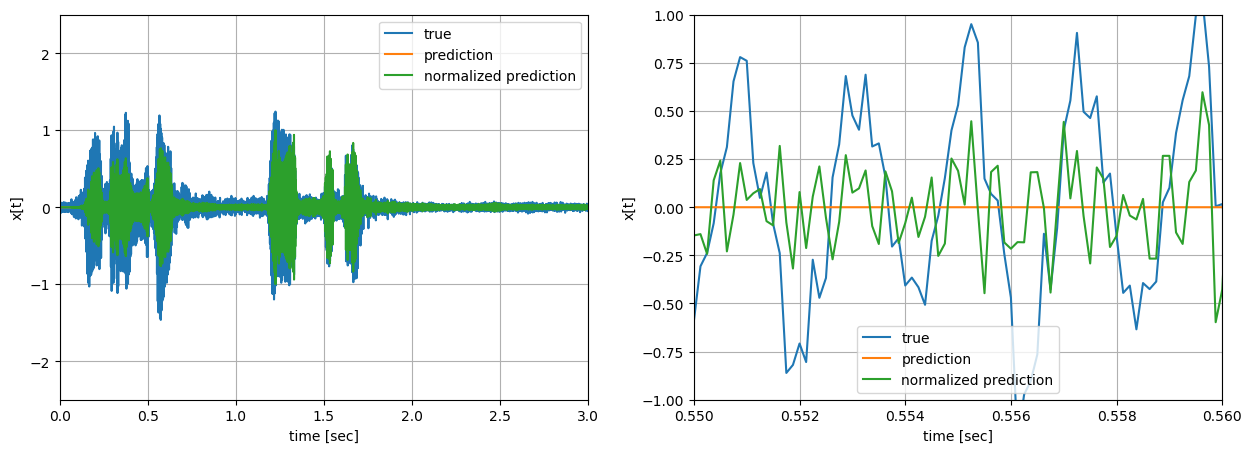

In [11]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
μ_x_pred_norm = μ_x_pred/maximum(μ_x_pred)

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(μ_x_pred)], μ_x_pred, label="prediction"), ax[1].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(μ_x_pred)], μ_x_pred, label="prediction"), ax[2].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-2.5, 2.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(0.55,0.56), ax[2].set_ylim(-1, 1), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

# create audioplayers
audioplayers(x_time, μ_x_pred, μ_x_pred_norm, fs=fs_desired)
;

## Performance metrics

In [12]:
MSE = 1/length(μ_x_pred) * sum(abs.(μ_x_pred - x_time[1:length(μ_x_pred)]).^2)

0.04123065236257246

In [13]:
MAE = 1/length(μ_x_pred) * sum(μ_x_pred - x_time[1:length(μ_x_pred)])

0.0025892028068464825

In [14]:
using Distributions;
logBME = Float64[]
for k = 1:length(μ_x)
    try 
        push!(logBME, logpdf(Distributions.MvNormal(μ_x[k], Matrix(Hermitian(Σ_x[k]))), x_time[(k-1)*32+1:k*32]))
    catch
    end
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

nr: 0       mean:NaN